In [41]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import enum
import scipy.optimize as optimize

In [42]:
# Set i= imaginary number
i   = complex(0.0,1.0)
# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

In [46]:
def CallPutOptionPriceCOSMthd(cf,CP,S0,r,tau,K,N,L):


    # cf   - Characteristic function as a functon, in the book denoted by \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - Interest rate (constant)
    # tau  - Time to maturity
    # K    - List of strikes
    # N    - Number of expansion terms
    # L    - Size of truncation domain (typ.:L=8 or L=10)

    # Reshape K to become a column vector

    if K is not np.array:
        K = np.array(K).reshape([len(K),1])

    # Assigning i=sqrt(-1)

    i = complex(0.0,1.0)
    x0 = np.log(S0 / K)

    # Truncation domain

    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)

    # Summation from k = 0 to k=N-1

    k = np.linspace(0,N-1,N).reshape([N,1])
    u = k * np.pi / (b - a)

    # Determine coefficients for put prices

    H_k = CallPutCoefficients(CP,a,b,k)
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k
    temp[0] = 0.5 * temp[0]
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))
    return value

# Determine coefficients for put prices

def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k = 2.0 / (b - a) * (- Chi_k + Psi_k)

    return H_k

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c

    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0))
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi *
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)

    value = {"chi":chi,"psi":psi }
    return value

# Black-Scholes call option price

def BS_Call_Option_Price(CP,S_0,K,sigma,tau,r):
    if K is list:
        K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0))
    * tau) / (sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    elif CP == OptionType.PUT:
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1)*S_0
    return value

# Implied volatility method

def ImpliedVolatilityXXX(CP,marketPrice,K,T,S_0,r):
    func = lambda sigma: np.power(BS_Call_Option_Price(CP,S_0,K,sigma,T,r) - marketPrice, 1.0)
    impliedVol = optimize.newton(func, 0.2, tol=1e-5)
    #impliedVol = optimize.brent(func, brack= (0.05, 0.9))
    return impliedVol

# Implied volatility method

def ImpliedVolatility(CP,marketPrice,K,T,S_0,r):

    # To determine initial volatility we define a grid for sigma
    # and interpolate on the inverse function

    sigmaGrid = np.linspace(0,2,250)
    optPriceGrid = BS_Call_Option_Price(CP,S_0,K,sigmaGrid,T,r)
    sigmaInitial = np.interp(marketPrice,optPriceGrid,sigmaGrid)
    #print("Initial volatility = {0}".format(sigmaInitial))

    # Use already determined input for the local-search (final tuning)

    func = lambda sigma: np.power(BS_Call_Option_Price(CP,S_0,K,sigma,T,r) - marketPrice, 1.0)
    impliedVol = optimize.newton(func, sigmaInitial, tol=1e-12)
    #print("Final volatility = {0}".format(impliedVol))
    return impliedVol

def ChFHestonModel(r,tau,kappa,gamma,vbar,v0,rho):
    i = complex(0.0,1.0)
    D1 = lambda u: np.sqrt(np.power(kappa-gamma*rho*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = lambda u: (kappa-gamma*rho*i*u-D1(u))/(kappa-gamma*rho*i*u+D1(u))
    C  = lambda u: (1.0-np.exp(-D1(u)*tau))/(gamma*gamma*(1.0-g(u)*np.exp(-D1(u)*tau)))*(kappa-gamma*rho*i*u-D1(u))

    # Note that we exclude the term -r*tau, as the discounting is performed in the COS method

    A  = lambda u: r * i*u *tau + kappa*vbar*tau/gamma/gamma *(kappa-gamma*rho*i*u-D1(u)) - 2*kappa*vbar/gamma/gamma*np.log((1.0-g(u)*np.exp(-D1(u)*tau))/(1.0-g(u)))

    # Characteristic function for the Heston model

    cf = lambda u: np.exp(A(u) + C(u)*v0)
    return cf

In [47]:
def mainCalculation():
    CP  = OptionType.CALL
    S0  = 100.0
    r   = 0.05
    tau = 2.0

    K = np.linspace(40,200,25)
    K = np.array(K).reshape([len(K),1])

    N = 500
    L = 5

    kappa = 0.1
    gamma = 0.1
    vbar  = 0.1
    rho   = -0.75
    v0    = 0.05

    # Effect of gamma
    plt.figure(figsize=(16,9))
    #plt.figure(1)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    gammaV = [0.1, 0.3, 0.5,0.9]
    legend = []
    for gammaTemp in gammaV:

       # Evaluate the Heston model
       # Compute ChF for the Heston model

       cf = ChFHestonModel(r,tau,kappa,gammaTemp,vbar,v0,rho)

       # The COS method

       valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L)

       # Implied volatilities

       IV =np.zeros([len(K),1])
       for idx in range(0,len(K)):
           IV[idx] = ImpliedVolatility(CP,valCOS[idx],K[idx],tau,S0,r)
       plt.plot(K,IV*100.0, "-s")
       legend.append('gamma={0}'.format(gammaTemp))
    plt.legend(legend)

    # Effect of kappa

    #plt.figure(2)
    plt.figure(figsize=(16,9))
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    kappaV = [0.1, 0.5, 1.0, 2.0]
    legend = []
    for kappaTemp in kappaV:

        # Evaluate the Heston model
       # Compute ChF for the Heston model

       cf = ChFHestonModel(r,tau,kappaTemp,gamma,vbar,v0,rho)

       # The COS method

       valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L)

       # Implied volatilities

       IV =np.zeros([len(K),1])
       for idx in range(0,len(K)):
           IV[idx] = ImpliedVolatility(CP,valCOS[idx],K[idx],tau,S0,r)
       plt.plot(K,IV*100.0, "-s")
       legend.append('kappa={0}'.format(kappaTemp))
    plt.legend(legend)

    # Effect of time-dependence in kappa

    #plt.figure(3)
    plt.figure(figsize=(16,9))
    plt.grid()
    plt.xlabel('strike, K')
    plt.xlabel('time-to-mautrity T')
    kappaV = [0.1, 0.3, 0.5, 1.0, 2.0]
    legend = []
    Ktemp = [S0]
    maturityGrid = np.linspace(0.1,25,40)

    for kappaTemp in kappaV:
        IV =np.zeros([len(maturityGrid),1])
        for idx, t in enumerate(maturityGrid):

            # Evaluate the Heston model

           cf = ChFHestonModel(r,t,kappaTemp,gamma,vbar,v0,rho)

           # The COS method

           valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, t, Ktemp, N, L)

           # Implied volatilities

           IV[idx] = ImpliedVolatility(CP,valCOS,Ktemp[0],t,S0,r)
        #print(IV)
        plt.plot(maturityGrid,IV*100.0, "-s")
        legend.append('kappa={0}'.format(kappaTemp))
    plt.legend(legend)

    # Effect of time-dependence in v_0

    #plt.figure(4)
    plt.figure(figsize=(16,9))
    plt.grid()
    plt.xlabel('time-to-mautrity T')
    plt.ylabel('implied volatility')
    v0V = [0.1, 0.3, 0.5, 1.0, 2.0]
    legend = []
    Ktemp = [S0]
    maturityGrid = np.linspace(0.1,25,40)

    for v0Temp in v0V:
        IV =np.zeros([len(maturityGrid),1])
        for idx, t in enumerate(maturityGrid):

            # Evaluate the Heston model

           cf = ChFHestonModel(r,t,kappa,gamma,vbar,v0Temp,rho)

           # The COS method

           valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, t, Ktemp, N, L)

           # Implied volatilities

           IV[idx] = ImpliedVolatility(CP,valCOS,Ktemp[0],t,S0,r)
        plt.plot(maturityGrid,IV*100.0, "-s")
        legend.append('v0={0}'.format(v0Temp))
    plt.legend(legend)

    # Effect of rho

    #plt.figure(5)
    plt.figure(figsize=(16,9))
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    rhoV = [0.0, -0.25, -0.5,  -0.9]
    legend = []
    for rhoTemp in rhoV:

       # Evaluate the Heston model
       # Compute ChF for the Heston model

       cf = ChFHestonModel(r,tau,kappa,gamma,vbar,v0,rhoTemp)

       # The COS method

       valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L)

       # Implied volatilities

       IV =np.zeros([len(K),1])
       for idx in range(0,len(K)):
           IV[idx] = ImpliedVolatility(CP,valCOS[idx],K[idx],tau,S0,r)
       plt.plot(K,IV*100.0, "-s")
       #plt.plot(K,valCOS)
       legend.append('rho={0}'.format(rhoTemp))
    plt.legend(legend)

    # Effect of vBar

    # plt.figure(6)
    plt.figure(figsize=(16,9))
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    vbarV = [0.03, 0.1, 0.2, 0.3]
    legend = []
    for vbarTemp in vbarV:

       # Evaluate the Heston model
       # Compute ChF for the Heston model

       cf = ChFHestonModel(r,tau,kappa,gamma,vbarTemp,v0,rho)

       # The COS method

       valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L)

       # Implied volatilities

       IV =np.zeros([len(K),1])
       for idx in range(0,len(K)):
           IV[idx] = ImpliedVolatility(CP,valCOS[idx],K[idx],tau,S0,r)
       plt.plot(K,IV*100.0, "-s")
       legend.append('vbar={0}'.format(vbarTemp))
    plt.legend(legend)

C:\Users\novik\AppData\Local\Temp\ipykernel_8616\544775407.py:86: RuntimeWarning: divide by zero encountered in true_divide
  d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0))


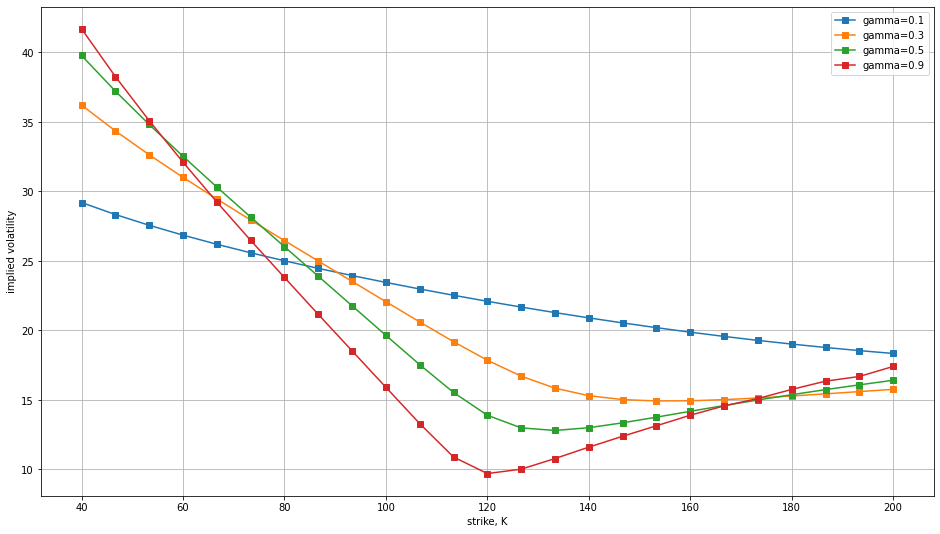

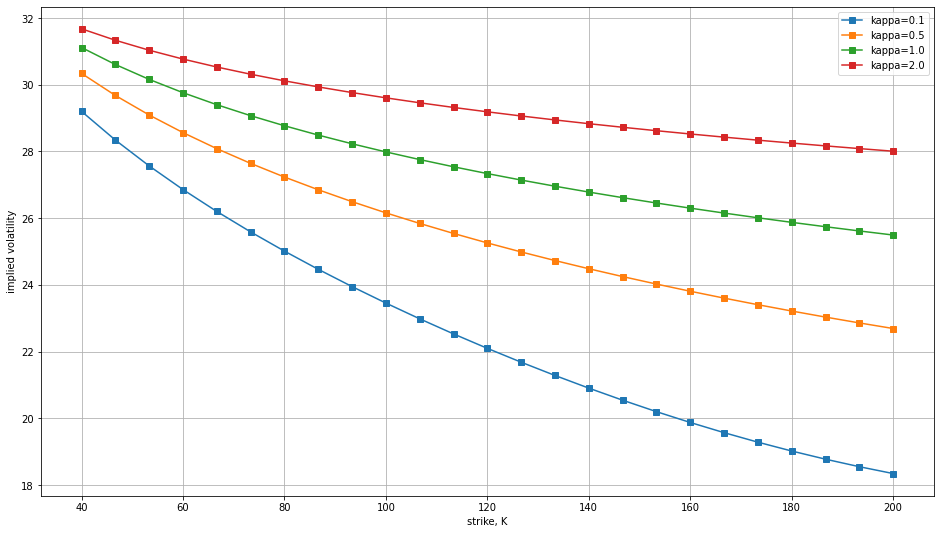

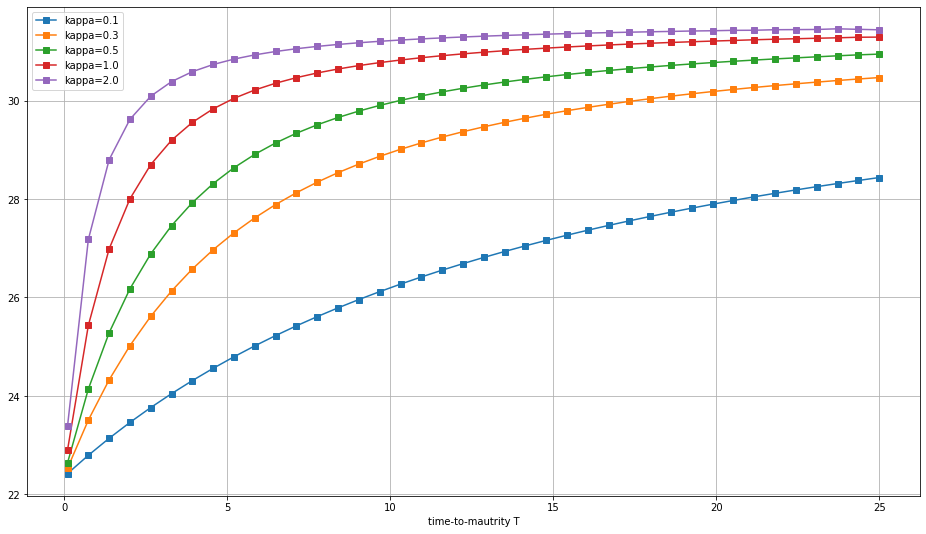

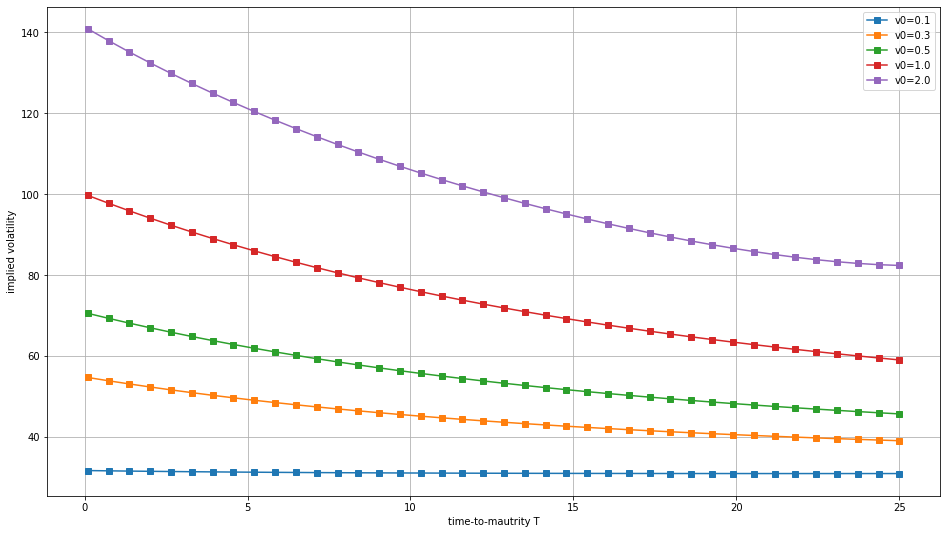

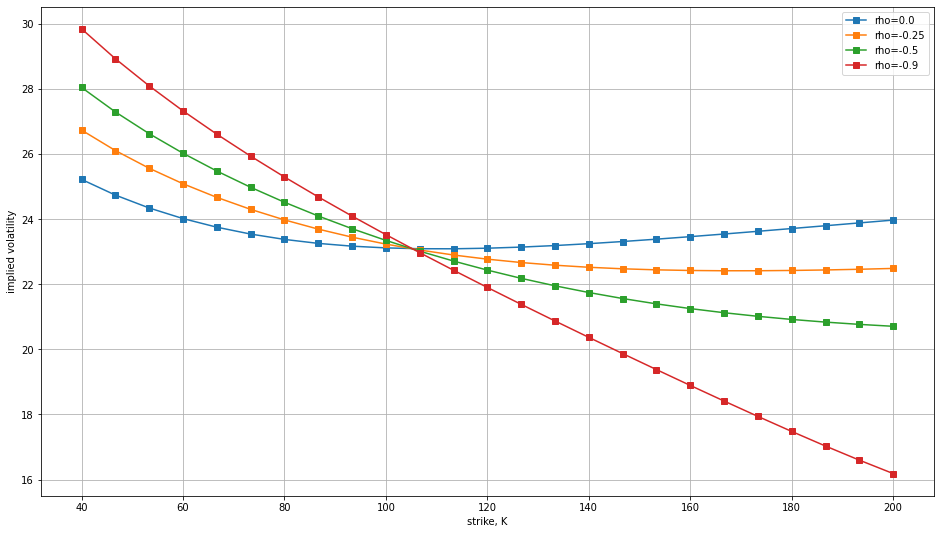

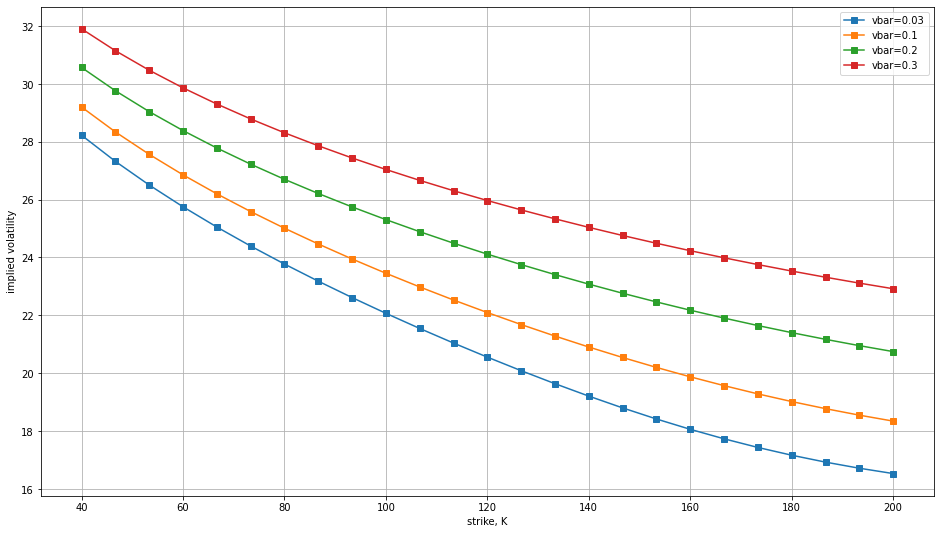

In [48]:
#plt.style.use("Solarize_Light2")
#plt.style.use("dark_background")
mainCalculation()